In [1]:
# Initialising required libraries
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from datetime import datetime
from sklearn import metrics

In [2]:
df_CPI = pd.read_csv("PCDA_UNCLEANED/ConsumerPriceIndex_UK.csv", parse_dates =["DATE"],index_col ="DATE")
df_CPI
df_CPI = df_CPI.CPALTT01GBM659N.resample('Q').mean()
type(df_CPI)
df_CPI = df_CPI.to_frame()
df_CPI.reset_index(inplace=True)
df_CPI.columns = ['DATE','CPI_growthrate']
df_CPI

,DATE,CPI_growthrate
0,1989-03-31,5.800000
1,1989-06-30,5.766667
2,1989-09-30,5.633333
3,1989-12-31,5.766667
4,1990-03-31,6.133333
...,...,...
130,2021-09-30,2.666667
131,2021-12-31,4.400000
132,2022-03-31,5.533333
133,2022-06-30,7.966667


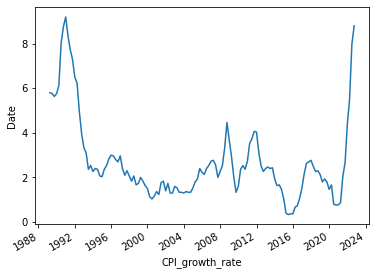

In [3]:
plt.plot(df_CPI['DATE'], df_CPI['CPI_growthrate'])
plt.xticks(rotation=30, ha='right')
plt.xlabel("CPI_growth_rate")
plt.ylabel("Date")
plt.rcParams['figure.figsize']=(12.8,7.2)

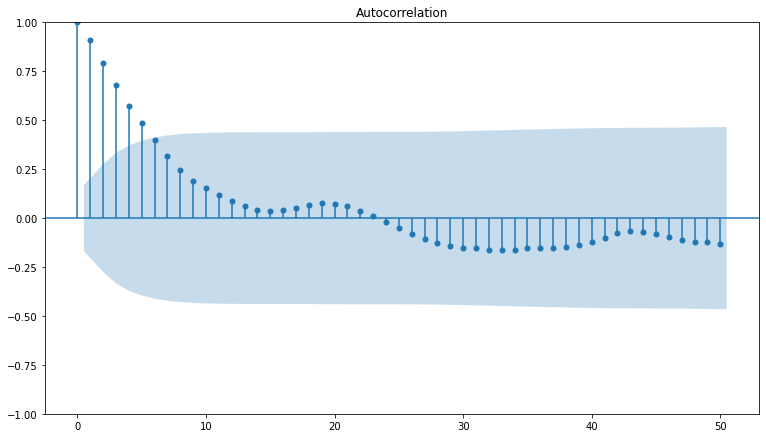

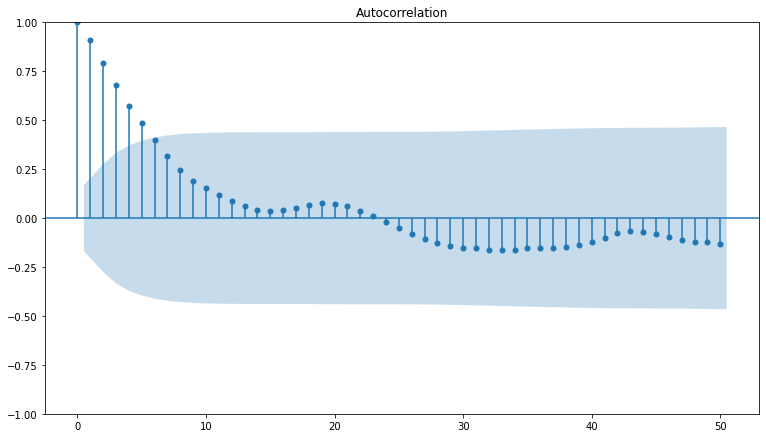

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
acf_plot = plot_acf(df_CPI['CPI_growthrate'],lags=50)
acf_plot

### According to the ACF plot, the autocorrelations are not declining quickly toward zero which indicates a trend component. As this is quarterly data and there are no significant spikes at every 4th lag, there is no seasonal component

### Due the pressence of Trend component, we can fit the data with below models
    1. Holt's linear Exponential 
    2. Damped trend Exponential
    3. Simple Linear Regression
    4. ARIMA
    
### As there is lot of flucation in this model we will aslo try with Holt's winter model

In [5]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import Holt,ExponentialSmoothing

# Split the data in to test and Train

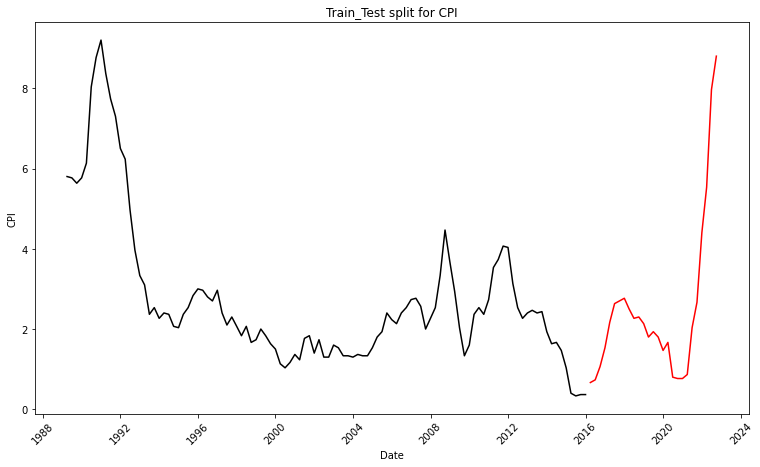

In [6]:
x1 = df_CPI.loc[:, df_CPI.columns == 'DATE'].to_numpy()
y1 = df_CPI.loc[:, df_CPI.columns == 'CPI_growthrate'].to_numpy()
x1_train, x1_test,y1_train, y1_test = train_test_split(x1,y1, test_size=0.20, shuffle=False)
x1_train
plt.plot(x1_train,y1_train, color = "black")
plt.plot(x1_test,y1_test, color = "red")
plt.ylabel('CPI')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train_Test split for CPI")
plt.rcParams['figure.figsize']=(12.8,7.2)
plt.show()

## It will be interesting to watch for individual performance of the model, as train data accounts for 2008 economic depression and test data accounts for pendamic depression

## Holt's linear Exponential model

In [7]:
def holt(x1,y1,y1_train,y1_test, period,x1_train,x1_test):
    plt1 = plt.plot(x1,y1,color='black')
    fit1 = Holt(y1_train).fit()
    fcast1 = fit1.forecast(period)
    #mse1_fit = ((fit1.fittedvalues - y1_train.squeeze()) ** 2).mean()
    #mse1_acc = ((fcast1 - y1_test.squeeze()) ** 2).mean()
    MAPE_fit= metrics.mean_absolute_percentage_error(y1_train, fit1.fittedvalues)
    MAPE_acc = metrics.mean_absolute_percentage_error(y1_test, fcast1)
    print('The MAPE for Model fit is',MAPE_fit)
    print('The MAPE for Model Acc is ',MAPE_acc)
    #print('The Root Mean Squared Error of Model fit is {}'.format(round(np.sqrt(mse1_fit), 2)))
    #print('The Root Mean Squared Error of Model accuracy is {}'.format(round(np.sqrt(mse1_acc), 2)))
    plt2 = plt.plot(x1_train,fit1.fittedvalues, color='blue')
    plt3 = plt.plot(x1_test,fcast1,color='red', marker="o")
    ax = plt.gca()
    print(fit1.summary())
    ax.legend([plt1[0],plt2[0],plt3[0]],["Actual","Holt's fit","Holt's Predict"])
    plt.xticks(rotation=30, ha='right')
    plt.title("Holt’s Linear Smoothing")
    plt.show()

The MAPE for Model fit is 0.13939385472395752
The MAPE for Model Acc is  1.171404039264174
                              Holt Model Results                              
Dep. Variable:                  endog   No. Observations:                  108
Model:                           Holt   SSE                             21.776
Optimized:                       True   AIC                           -164.941
Trend:                       Additive   BIC                           -154.213
Seasonal:                        None   AICC                          -164.110
Seasonal Periods:                None   Date:                 Mon, 12 Dec 2022
Box-Cox:                        False   Time:                         17:28:42
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000    

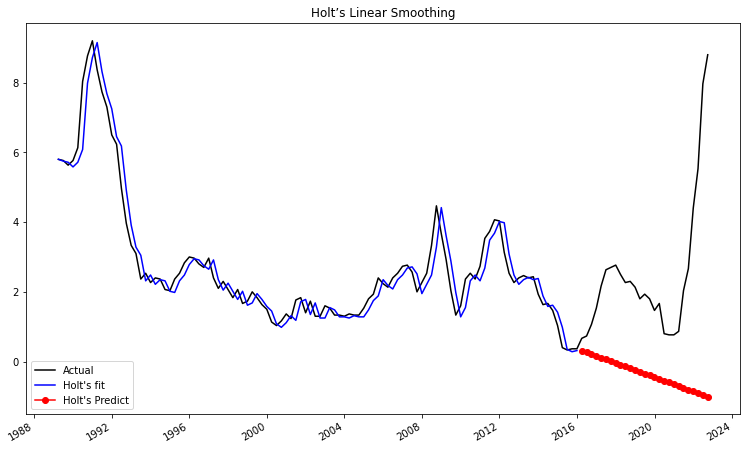

In [8]:
holt(x1,y1, y1_train,y1_test,len(x1_test),x1_train,x1_test)

# The level smoothing parameter is "1.0" which indicates that a higher weight is assigned to the most recent observations.
### The trend smoothing parameter is "0.0" indicates that the slope of the time series is not changing.
### The MAPE for Model Acc is "1.17", which indicate model peformance not good, but there are chances of overfitting of data.

# Damped Trend Model


In [10]:
def damped(x1,y1,y1_train,y1_test, period,x1_train,x1_test):
    plt1 = plt.plot(x1,y1,color='black')
    fit1 = ExponentialSmoothing(y1_train,trend='add',seasonal=None, damped_trend=True).fit()
    fcast1 = fit1.forecast(period)
   # mse1_fit = ((fit1.fittedvalues - y1_train.squeeze()) ** 2).mean()
   # mse1_acc = ((fcast1 - y1_test.squeeze()) ** 2).mean()
    MAPE_fit= metrics.mean_absolute_percentage_error(y1_train, fit1.fittedvalues)
    MAPE_acc = metrics.mean_absolute_percentage_error(y1_test, fcast1)
    print("The MAPE for Model fit is {}",MAPE_fit)
    print("The MAPE for Model Acc is {}",MAPE_acc)
    #print('The Root Mean Squared Error of Model fit is {}'.format(round(np.sqrt(mse1_fit), 2)))
    #print('The Root Mean Squared Error of Model accuracy is {}'.format(round(np.sqrt(mse1_acc), 2)))
    plt2 = plt.plot(x1_train,fit1.fittedvalues, color='blue')
    plt3 = plt.plot(x1_test,fcast1,color='red', marker="o")
    print(fit1.summary())
    ax = plt.gca()
    ax.legend([plt1[0],plt2[0],plt3[0]],["Actual","Damped fit","Damped Predict"])
    plt.xticks(rotation=30, ha='right')
    plt.title("Damped Exponential Smoothing")
    plt.show()

The MAPE for Model fit is {} 0.1457886332382239
The MAPE for Model Acc is {} 0.8041818239353101
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  108
Model:             ExponentialSmoothing   SSE                             19.375
Optimized:                         True   AIC                           -175.558
Trend:                         Additive   BIC                           -162.147
Seasonal:                          None   AICC                          -174.438
Seasonal Periods:                  None   Date:                 Mon, 12 Dec 2022
Box-Cox:                          False   Time:                         17:29:24
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level  

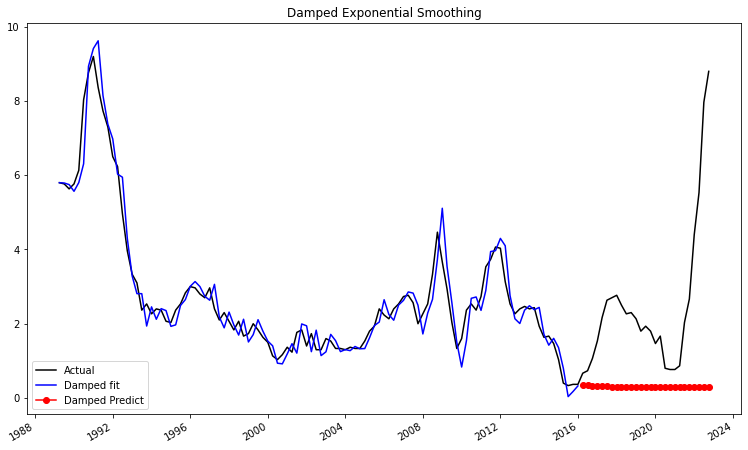

In [11]:
damped(x1,y1, y1_train,y1_test,len(x1_test),x1_train,x1_test)

### The level smoothing parameter is "1.00" which indicates that a higher weight is assigned to the most recent observations.
### The trend smoothing parameter is "0.55" indicates that the slope of the time series is changing.
### The damping smoothing parameter is "0.800" which indicates that more damping is applied.
### The MAPE for Model Acc is "0.80", which indicate model peformance is really good.

# Simple Linear Regression

In [12]:
# Importing Linear Regression model from scikit learn
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [13]:
df_CPI['DateIndex'] = np.arange(len(df_CPI.index))
X = df_CPI.loc[:, df_CPI.columns == 'DateIndex']
y = df_CPI.loc[:, df_CPI.columns == 'CPI_growthrate']

X = np.array(X).reshape((-1, 1))
X_train, X_test,y_train, y_test = train_test_split(X,y, test_size=0.20, shuffle=False)
X_test
X_test = np.array(X_test).reshape((-1, 1))

In [14]:
# fit the regression model
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         CPI_growthrate   R-squared (uncentered):                   0.324
Model:                            OLS   Adj. R-squared (uncentered):              0.318
Method:                 Least Squares   F-statistic:                              51.26
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                    1.07e-10
Time:                        17:31:09   Log-Likelihood:                         -261.24
No. Observations:                 108   AIC:                                      524.5
Df Residuals:                     107   BIC:                                      527.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0304      0.004      7.160      0.000       0.022       0.039
==============================================================================
Omnibus:                       32.718   Durbin-Watson:                   0.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.952
Skew:                           1.428   Prob(JB):                     8.63e-12
Kurtosis:                       4.779   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
y_pred = model.predict(X_test)
y_pred

array([3.28164312, 3.31202871, 3.34241429, 3.37279987, 3.40318546,
       3.43357104, 3.46395663, 3.49434221, 3.5247278 , 3.55511338,
       3.58549897, 3.61588455, 3.64627013, 3.67665572, 3.7070413 ,
       3.73742689, 3.76781247, 3.79819806, 3.82858364, 3.85896923,
       3.88935481, 3.91974039, 3.95012598, 3.98051156, 4.01089715,
       4.04128273, 4.07166832])

In [16]:
MAPE_train=metrics.mean_absolute_percentage_error(y_train, model.fittedvalues)
print("The MAPE for Model fit is",MAPE_train)
MAPE_test=metrics.mean_absolute_percentage_error(y_test, y_pred)
print("The MAPE for Model Acc is",MAPE_test)

The MAPE for Model fit is 0.7380421216481108
The MAPE for Model Acc is 1.4182537080059665


In [17]:
y_train = np.array(y_train).reshape((-1, 1))
model.fittedvalues = np.array(model.fittedvalues).reshape((-1, 1))

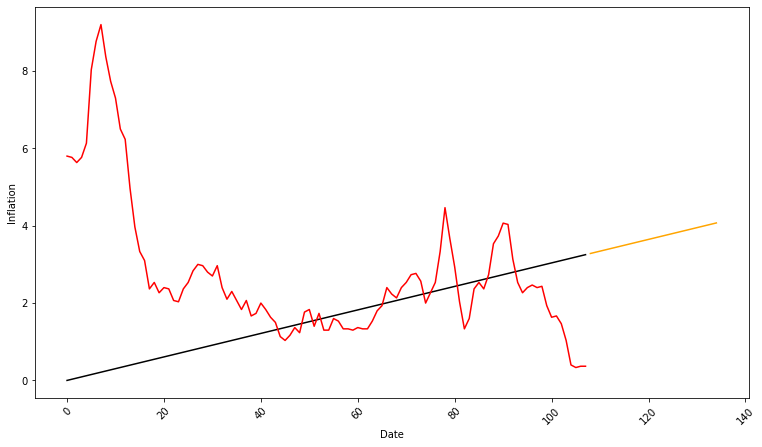

In [18]:
plt.plot(X_train,model.fittedvalues, color = "black")
plt.plot(X_train,y_train, color = "red")
plt.plot(X_test,y_pred, color = "Orange")
plt.ylabel('Inflation')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.rcParams['figure.figsize']=(12.8,7.2)
plt.show()

# Model Assumptions
## 1.	First, we assume that the relationship between the forecast variable and the predictor variable is linear
### The relationship between the forecast variable “CPI_growthrate” and the predictor variable is linear.
## 2.Second, we make the following assumptions about the errors:     
        * Residuals are normally distributed
        * Residuals have constant variance 
        * Residual terms are independent

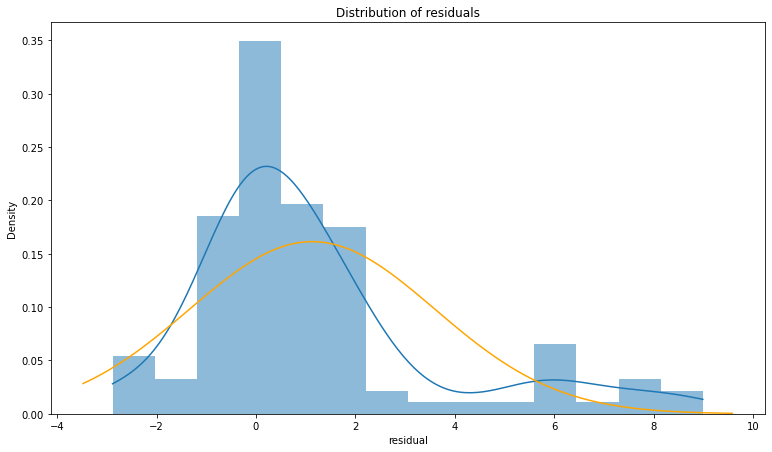

In [19]:
from scipy import stats
mu, std = stats.norm.fit(model.resid)
mu, std
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, ax = plt.subplots()
# plot the residuals
sns.histplot(x=model.resid, ax=ax, stat="density", linewidth=0, kde=True)
ax.set(title="Distribution of residuals", xlabel="residual")

# plot corresponding normal curve
xmin, xmax = plt.xlim() # the maximum x values from the histogram above
x = np.linspace(xmin, xmax, 100) # generate some x values
p = stats.norm.pdf(x, mu, std) # calculate the y values for the normal curve
sns.lineplot(x=x, y=p, color="orange", ax=ax)
plt.show()

## According to the histogram, the residuals appear not normally distributed, The assumption is not true

[Text(0.5, 0, 'Residuals'), Text(0, 0.5, 'Predicted Values')]

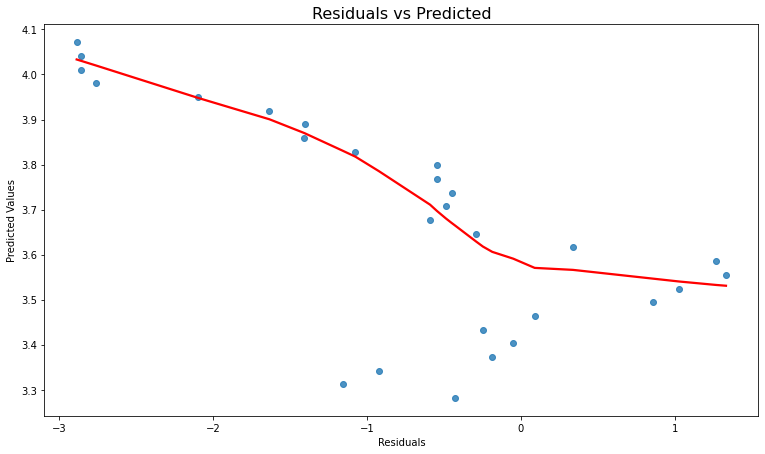

In [20]:
pred_resid = model.resid.tail(len(y_pred))

#Residual Vs Predicted Plot
fig, ax = plt.subplots(1,1)
sns.regplot(x=pred_resid, y=y_pred, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs Predicted', fontsize=16)
ax.set(xlabel='Residuals', ylabel='Predicted Values')

## The residual vs. predicted value scatterplot shows a pattern that indicates that the equal variances assumption is not correct.

In [21]:
#perform Durbin-Watson test
from statsmodels.stats.stattools import durbin_watson

durbin_watson(model.resid)

0.02817249560865903

## As the Durbin-Watson statistic ranges from 0-4. The DW statistic close to zero indicate that there is positive serial correlation

# Model Evaluation
## 1.	Is the model logical? 
### The model is logical because the slope is positive which makes sense. With the increase in time there is increase in CPI
## 2.	Is the slope term statistically significant? 
### The p-value for the slope term is less than alpha, so independent variable is a significant predictor
## 3.	What percent of the variation in the dependent variable is explained by variation in the independent variable 
### R2 = 32% so 32% of the variation in the dependent variable is explained by the independent variable

## ARIMA 

In [23]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [24]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.model_selection import train_test_split

In [25]:
df_CPI.head()

,DATE,CPI_growthrate,DateIndex
0,1989-03-31,5.800000,0
1,1989-06-30,5.766667,1
2,1989-09-30,5.633333,2
3,1989-12-31,5.766667,3
4,1990-03-31,6.133333,4


### Check if the data is stationary using Dickey-Fuller test 

In [26]:
ad_fuller_result = adfuller(df_CPI['CPI_growthrate'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.205717088188844
p-value: 0.20417703112457303


### The p value is higher than alpha so we cannot reject null hypothesis and must assume the data is not stationary

### Differencing can be done to make the data stationary 

In [27]:
df_CPI['CPI_growthrate_diff'] = df_CPI['CPI_growthrate'] - df_CPI['CPI_growthrate'].shift(1)

In [28]:
df_CPI['CPI_growthrate_diff'].head()

0         NaN
1   -0.033333
2   -0.133333
3    0.133333
4    0.366667
Name: CPI_growthrate_diff, dtype: float64

In [29]:
df_CPI = df_CPI.dropna()
df_CPI

,DATE,CPI_growthrate,DateIndex,CPI_growthrate_diff
1,1989-06-30,5.766667,1,-0.033333
2,1989-09-30,5.633333,2,-0.133333
3,1989-12-31,5.766667,3,0.133333
4,1990-03-31,6.133333,4,0.366667
5,1990-06-30,8.033333,5,1.900000
...,...,...,...,...
130,2021-09-30,2.666667,130,0.633333
131,2021-12-31,4.400000,131,1.733333
132,2022-03-31,5.533333,132,1.133333
133,2022-06-30,7.966667,133,2.433333


### Check again if the differenced data is stationary 

In [30]:
ad_fuller_result = adfuller(df_CPI['CPI_growthrate_diff'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.249539826315906
p-value: 0.0005426000594683838


### The p value is lower than alpha so we can assume that the data is stationary 

<AxesSubplot:>

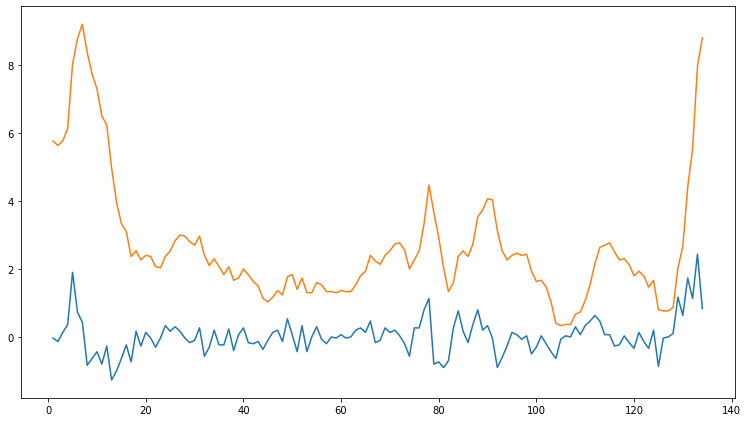

In [31]:
#viewing the stationary data 
df_CPI['CPI_growthrate_diff'].plot()
df_CPI['CPI_growthrate'].plot() 

### Yellow line is the original data and blue is the differnced data. We can see more stationarity within the blue line

### Plotting ACF and PACF of differenced data to find which ARIMA model to choose 

C:\Users\Students\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


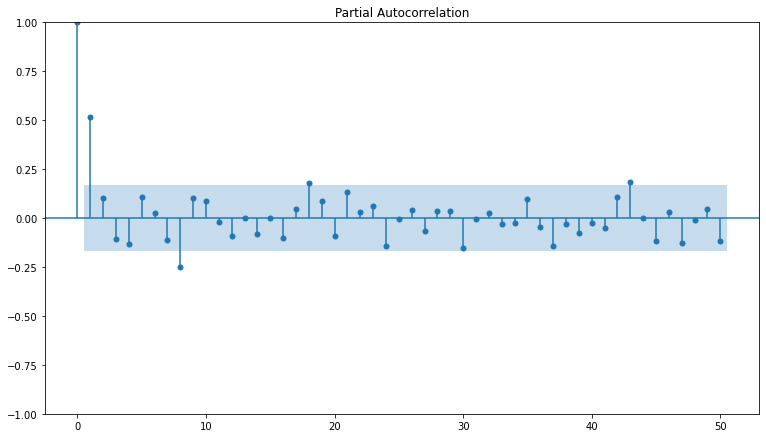

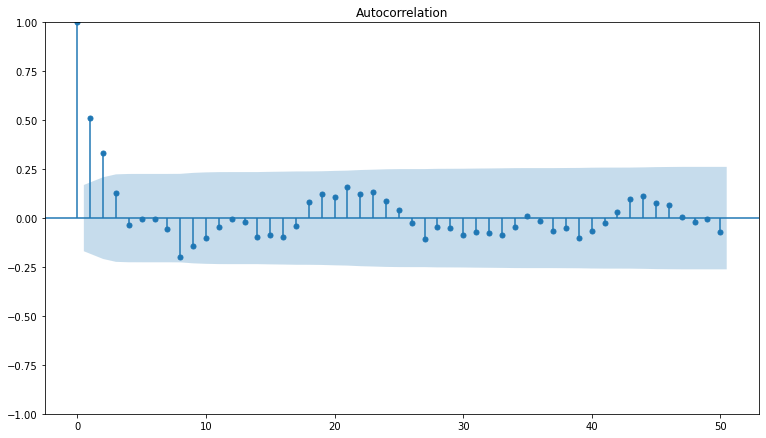

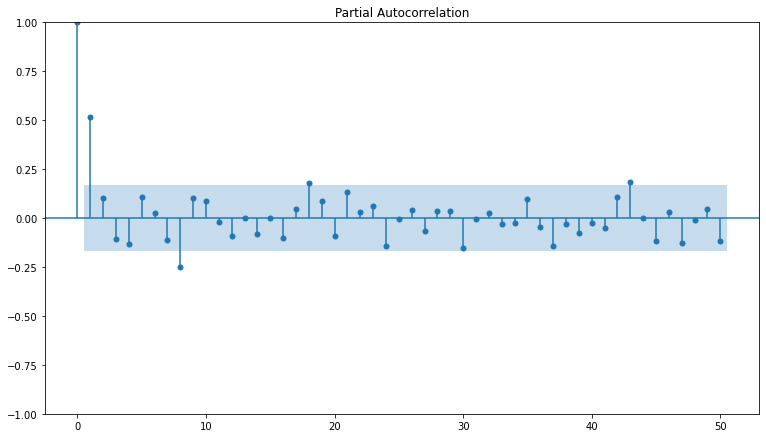

In [32]:
plot_acf(df_CPI['CPI_growthrate_diff'],lags=50)
plot_pacf(df_CPI['CPI_growthrate_diff'],lags=50)
#ARIMA(1,1,1)

### The arima model can be split up into AR(p), I(d) and MA(q). In the PACF graph, we can see one significant lag within the first 5 lags, making the AR equal to 1. In the ACF graph, we also see two significant lags, making the MA equal to 2. The I or differencing term in the arima model is equal to 1 since we did one level of differencing to make the data stationary. This makes our model ARIMA(1,1,2). Next, we build the model based on these specifications.

In [33]:
train = df_CPI.loc[:106]
test = df_CPI.loc[107:]

In [34]:
train

,DATE,CPI_growthrate,DateIndex,CPI_growthrate_diff
1,1989-06-30,5.766667,1,-0.033333
2,1989-09-30,5.633333,2,-0.133333
3,1989-12-31,5.766667,3,0.133333
4,1990-03-31,6.133333,4,0.366667
5,1990-06-30,8.033333,5,1.900000
...,...,...,...,...
102,2014-09-30,1.466667,102,-0.200000
103,2014-12-31,1.033333,103,-0.433333
104,2015-03-31,0.400000,104,-0.633333
105,2015-06-30,0.333333,105,-0.066667


In [35]:
test

,DATE,CPI_growthrate,DateIndex,CPI_growthrate_diff
107,2015-12-31,0.366667,107,0.000000
108,2016-03-31,0.666667,108,0.300000
109,2016-06-30,0.733333,109,0.066667
110,2016-09-30,1.066667,110,0.333333
111,2016-12-31,1.533333,111,0.466667
112,2017-03-31,2.166667,112,0.633333
113,2017-06-30,2.633333,113,0.466667
114,2017-09-30,2.700000,114,0.066667
115,2017-12-31,2.766667,115,0.066667
116,2018-03-31,2.500000,116,-0.266667


In [36]:
model = ARIMA(train['CPI_growthrate'], order = (1, 1, 2))
results = model.fit()

C:\Users\Students\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Students\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Students\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [37]:
prediction = results.predict(start=106, end=132, dynamic=False)
prediction.columns = ["predicted_values"]
test["predicted_values"] = prediction

C:\Users\Students\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Students\AppData\Local\Temp\ipykernel_5596\2798649467.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_values"] = prediction


In [38]:
test

,DATE,CPI_growthrate,DateIndex,CPI_growthrate_diff,predicted_values
107,2015-12-31,0.366667,107,0.000000,0.421302
108,2016-03-31,0.666667,108,0.300000,0.425628
109,2016-06-30,0.733333,109,0.066667,0.426790
110,2016-09-30,1.066667,110,0.333333,0.427102
111,2016-12-31,1.533333,111,0.466667,0.427186
112,2017-03-31,2.166667,112,0.633333,0.427209
113,2017-06-30,2.633333,113,0.466667,0.427215
114,2017-09-30,2.700000,114,0.066667,0.427216
115,2017-12-31,2.766667,115,0.066667,0.427217
116,2018-03-31,2.500000,116,-0.266667,0.427217


In [39]:
test = test.dropna()
test

,DATE,CPI_growthrate,DateIndex,CPI_growthrate_diff,predicted_values
107,2015-12-31,0.366667,107,0.000000,0.421302
108,2016-03-31,0.666667,108,0.300000,0.425628
109,2016-06-30,0.733333,109,0.066667,0.426790
110,2016-09-30,1.066667,110,0.333333,0.427102
111,2016-12-31,1.533333,111,0.466667,0.427186
112,2017-03-31,2.166667,112,0.633333,0.427209
113,2017-06-30,2.633333,113,0.466667,0.427215
114,2017-09-30,2.700000,114,0.066667,0.427216
115,2017-12-31,2.766667,115,0.066667,0.427217
116,2018-03-31,2.500000,116,-0.266667,0.427217


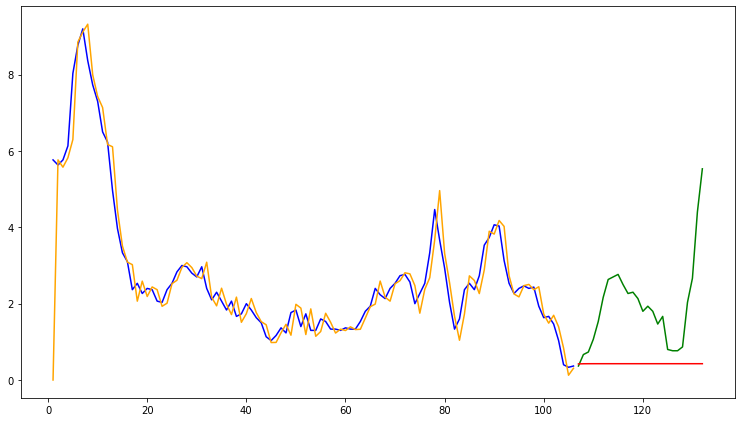

In [40]:
plt.plot(train['CPI_growthrate'], color = 'Blue', label = "Train")
plt.plot(test['CPI_growthrate'], color = 'Green', label = "Test")
plt.plot(test['predicted_values'], color ='Red', label = "Prediction")
plt.plot(results.fittedvalues, color='Orange')

In [41]:
MSE_test=metrics.mean_squared_error(test['CPI_growthrate'], test['predicted_values'])
MAPE_train=metrics.mean_absolute_percentage_error(train['CPI_growthrate'], results.fittedvalues)
print("The MAPE for Model Accuracy(test) is",MAPE_test)
print("The MAPE for Model fit(train) is",MAPE_train)

The MAPE for Model Accuracy(test) is 1.4182537080059665
The MAPE for Model fit(train) is 0.14716522776174523


### The predicted values are not able to identify the curves in the graph and are graphed as more of a straight line. The MAPE for model fit is low showing that it is able to fit to the train data well. The model accuracy is very high indicating that it is not able to fit well to the test data or new data. 

## Among the Holt's, Damped, simple regression, and ARIMA, Damped Trend Exponential model performed better. So we now forecast the Interest rate for next two quarter using Damped Trend Exponential model.

# Model Predictions for Next two quarters - using Damped Trend Exponential

In [43]:
fit_damp = ExponentialSmoothing(df_CPI['CPI_growthrate'],trend='add',seasonal=None, damped_trend=True).fit()
fcast_damp = fit_damp.forecast(2)

C:\Users\Students\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Students\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [44]:
fcast_damp =  fcast_damp.to_frame()
fcast_damp.columns = ['CPI_growthrate']
fcast_damp

,CPI_growthrate
134,9.721684
135,10.436528
